In [1]:
!pip install ../dist/rekomenda-0.1.0-py3-none-any.whl --quiet

In [12]:
import numpy as np 
import matplotlib.pyplot as plt
import time

from rekomenda.utils import load_movielens_data, find_movie_by_title
from rekomenda.als import OptimizedLatentFactorALS
from rekomenda.analyser import ALSRecommendationAnalyzer

In [3]:
RATINGS_PATH = '../ml-32m/ratings.csv'
MOVIES_PATH = '../ml-32m/movies.csv'

In [4]:
train_csr, train_csc, test_data, item_id_to_name, movie_id_to_idx = load_movielens_data(ratings_path=RATINGS_PATH, movies_path=MOVIES_PATH)

Loading MovieLens data with chunked processing...
Loading movie metadata...
Loaded 87585 movies

First pass: Collecting unique users and items...
  Processed 5,000,000 ratings...
  Processed 10,000,000 ratings...
  Processed 15,000,000 ratings...
  Processed 20,000,000 ratings...
  Processed 25,000,000 ratings...
  Processed 30,000,000 ratings...
Found 200,948 unique users
Found 84,432 unique items
Total ratings: 32,000,204

Creating ID mappings...

Second pass: Loading ratings and creating train/test split...
  Processed 5,000,000 ratings...
  Processed 10,000,000 ratings...
  Processed 15,000,000 ratings...
  Processed 20,000,000 ratings...
  Processed 25,000,000 ratings...
  Processed 30,000,000 ratings...

Concatenating chunks...
Train: 25,601,564 ratings (80.0%)
Test: 6,398,640 ratings (20.0%)

Creating training sparse matrices...
Matrix: 200948 users × 80229 items
Sparsity: 0.159%

✓ Data loaded successfully with chunked processing
✓ Memory efficient: Processed 32,000,204 ratings

In [5]:
train_als_model = OptimizedLatentFactorALS(lambda_reg=0.1, n_factors=20, use_parallel=True)

In [7]:
start = time.time()
train_als_model.fit(train_csr, train_csc, n_iterations=50, compute_metrics_every=5)
end = time.time()

print(f'Total time taken: {end - start}')

Iteration 5/50 - RMSE: 0.6611, NLL: 5778003.0000
Iteration 10/50 - RMSE: 0.6420, NLL: 5426127.5000
Iteration 15/50 - RMSE: 0.6365, NLL: 5316456.5000
Iteration 20/50 - RMSE: 0.6341, NLL: 5263523.5000
Iteration 25/50 - RMSE: 0.6328, NLL: 5232194.0000
Iteration 30/50 - RMSE: 0.6319, NLL: 5211305.0000
Iteration 35/50 - RMSE: 0.6313, NLL: 5196314.0000
Iteration 40/50 - RMSE: 0.6309, NLL: 5185042.0000
Iteration 45/50 - RMSE: 0.6306, NLL: 5176295.0000
Iteration 50/50 - RMSE: 0.6303, NLL: 5169373.5000
Total time taken: 1019.6102905273438


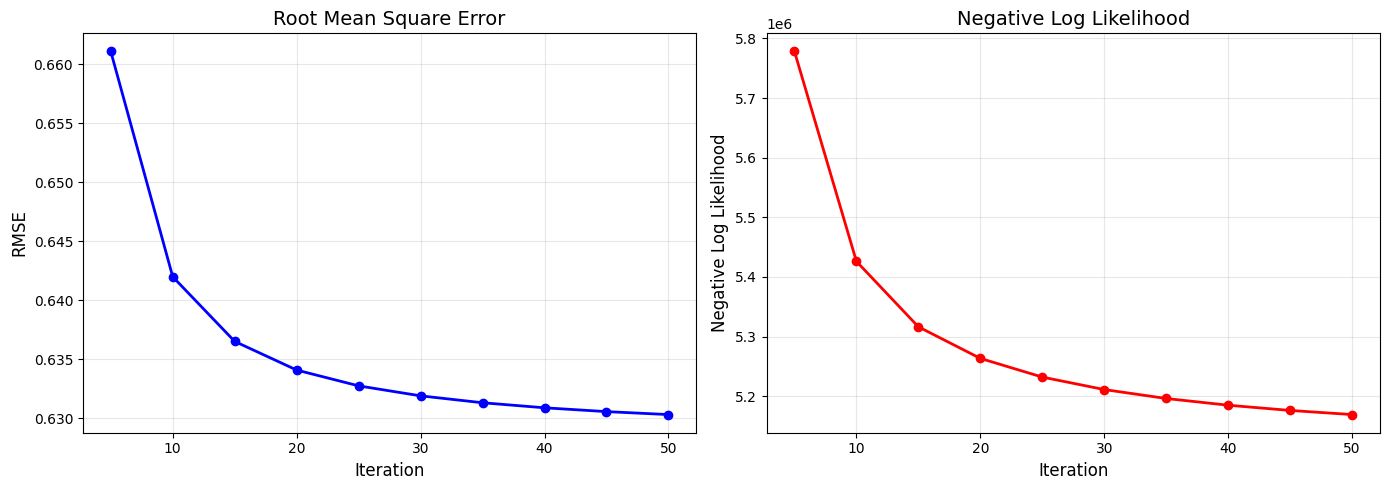

In [8]:
train_als_model.plot_metrics(output='pics/test-model.pdf')

In [10]:
analyser = ALSRecommendationAnalyzer(model=train_als_model, item_id_to_name=item_id_to_name)

In [14]:
lotr_matches = find_movie_by_title("Lord of the Rings", item_id_to_name)
if lotr_matches:
    print("\n\nTest 1: Lord of the Rings Fan")
    print("-" * 80)
    fellowship_id, fellowship_name = lotr_matches[0]
    other_lotr_ids = [item_id for item_id, _ in lotr_matches[1:3]]
    
    analyser.test_recommendation_quality(
        seed_movie_id=fellowship_id,
        seed_movie_name=fellowship_name,
        seed_rating=5.0,
        expected_similar_ids=other_lotr_ids,
        top_k=10
    )



Test 1: Lord of the Rings Fan
--------------------------------------------------------------------------------

RECOMMENDATION TEST: User who gave '"Lord of the Rings' a 5.0/5

Top 10 Recommendations:
--------------------------------------------------------------------------------
 1. Christmas Carol: The Movie (2001)                  (predicted: 6.67)
 2. Monte Carlo (2011)                                 (predicted: 6.43)
 3. Protagonist (2007)                                 (predicted: 6.41)
 4. Holy Matrimony (1943)                              (predicted: 6.41)
 5. "Good Night to Die                                 (predicted: 6.37)
 6. "Honeymooners                                      (predicted: 6.13)
 7. Young Sherlock Holmes (1985)                       (predicted: 6.05)
 8. "Hidden Assassin (Shooter                          (predicted: 6.04)
 9. "Marine 2                                          (predicted: 6.03)
10. That's The Way I Like It (a.k.a. Forever Fever) (1998) 

In [16]:
sw_matches = find_movie_by_title("Star Wars", item_id_to_name)
if sw_matches:
    print("\n\nTest 2: Star Wars Fan")
    print("-" * 80)
    sw_id, sw_name = sw_matches[0]

    analyser.test_recommendation_quality(
        seed_movie_id=sw_id,
        seed_movie_name=sw_name,
        seed_rating=5.0,
        top_k=10
    )



Test 2: Star Wars Fan
--------------------------------------------------------------------------------

RECOMMENDATION TEST: User who gave 'Star Wars: Episode IV - A New Hope (1977)' a 5.0/5

Top 10 Recommendations:
--------------------------------------------------------------------------------
 1. "Art of War                                        (predicted: 5.60)
 2. Penelope (2006)                                    (predicted: 5.48)
 3. Departure (2016)                                   (predicted: 5.17)
 4. Invisible (2017)                                   (predicted: 5.13)
 5. Stalingrad (2013)                                  (predicted: 5.06)
 6. Ek Ladki Ko Dekha Toh Aisa Laga (2019)             (predicted: 5.05)
 7. Riding with Death (1976)                           (predicted: 5.04)
 8. Life Partners (2014)                               (predicted: 5.03)
 9. "Karate Kid                                        (predicted: 5.03)
10. Within (2016)                           

In [32]:
polarizing = analyser.find_polarizing_movies(top_k=20)
for rank, (item_id, norm, name) in enumerate(polarizing, 1):
    print(f"{rank:2d}. {name:60s} | Norm: {norm:.4f}")
    
print("\n\nTop 20 Most Polarizing Movies (by combined metric):")
print("-" * 80)
stats = analyser.compute_rating_statistics_fast(train_csc, top_k=20)
# print(stats.columns)
for i, stat in stats.iterrows():
    print(stat)
    print(i)
    print(f"{i:2d}. {stat['item_name']:50s} | n_ratings={stat['n_ratings']:5d} | "
            f"std={stat['rating_std']:.3f} | norm={stat['factor_norm']:.3f} | "
            f"polarization={stat['polarization_score']:.4f}")
    

 1. "Yes Men Fix the World                                       | Norm: 14.3448
 2. "Kid from Brooklyn                                           | Norm: 13.8425
 3. Pouic-Pouic (1963)                                           | Norm: 12.3209
 4. Danton (1983)                                                | Norm: 11.8096
 5. Heavy Metal Parking Lot (1986)                               | Norm: 10.8748
 6. Grateful Dead (1995)                                         | Norm: 9.9732
 7. Outsourced (2006)                                            | Norm: 9.2738
 8. Back Soon (2007)                                             | Norm: 8.8637
 9. Anna Held (1901)                                             | Norm: 8.5017
10. The Adventures of Jurassic Pet (2019)                        | Norm: 7.9793
11. Dear Pillow (2004)                                           | Norm: 7.9316
12. And Along Come Tourists (Am Ende kommen Touristen) (2007)    | Norm: 7.9045
13. Quest (1996)                   

In [34]:
analyser.plot_embedding_scatter(
        n_items=1000,
        min_ratings=50,
        csc_matrix=csc_matrix,
        figsize=(16, 12),
        alpha=0.5,
        show_labels=False,
        label_top_n=30
    )

AttributeError: 'ALSRecommendationAnalyzer' object has no attribute 'plot_embedding_scatter'